### Requirements:

In [1]:
#Update pip3
!sudo pip3 install --upgrade -q pip

In [2]:
#Update to Tensorflow 1.13.1 ; Required for running Magenta
!pip3 install -q tensorflow-rocm==1.13.1

In [3]:
#Downgrade to Numpy 1.16.1 to solve ValueError: Object arrays cannot be loaded when allow_pickle=False
!pip3 install -q numpy==1.16.1

In this notebook, we will show how to load pre-trained models and draw things with sketch-rnn

In [4]:
# import the required libraries
import numpy as np
import time
import random
#import cPickle no longer supported for Python 3
import _pickle as cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

In [5]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [6]:
#Changed to pip3
!pip3 install -qU svgwrite

In [7]:
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [8]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)

INFO:tensorflow:TensorFlow Version: 1.13.1


In [9]:
#Required for Magenta installation
!apt-get install -yq build-essential libasound2-dev libjack-dev

Reading package lists...
Building dependency tree...
Reading state information...
build-essential is already the newest version (12.1ubuntu2).
libasound2-dev is already the newest version (1.1.0-0ubuntu1).
libjack-dev is already the newest version (1:0.124.1+20140122git5013bed0-3build2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [10]:
#Changed to pip3
!pip3 install -q magenta

ERROR: Cannot uninstall 'httplib2'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [11]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [12]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [13]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = '/tmp/sketch_rnn/models'
model_dir = '/tmp/sketch_rnn/models/aaron_sheep/layer_norm'

In [14]:
download_pretrained_models(models_root_dir=models_root_dir)

INFO:tensorflow:Downloading pretrained models from http://download.magenta.tensorflow.org/models/sketch_rnn.zip...
INFO:tensorflow:Download complete.
INFO:tensorflow:Unzipping /tmp/sketch_rnn/models/sketch_rnn.zip...
INFO:tensorflow:Unzipping complete.


In [15]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [16]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep//aaron_sheep.npz
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [17]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Model using gpu.
I

In [18]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [19]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/aaron_sheep/layer_norm/vector


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [20]:
def encode(input_strokes):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)))
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [21]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

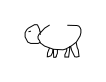

In [22]:
# get a sample drawing from the test set, and render it to .svg
stroke = test_set.random_sample()
draw_strokes(stroke)

Let's try to encode the sample stroke into latent vector $z$

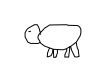

In [23]:
z = encode(stroke)

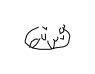

In [24]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

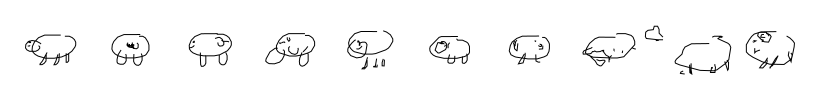

In [25]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

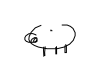

In [26]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

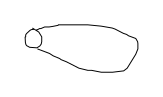

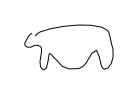

In [27]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [28]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [29]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

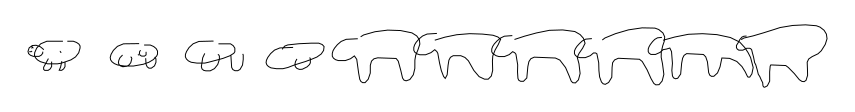

In [30]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [31]:
model_dir = '/tmp/sketch_rnn/models/flamingo/lstm_uncond'

In [32]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [33]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [34]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [35]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/flamingo/lstm_uncond/vector


In [36]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

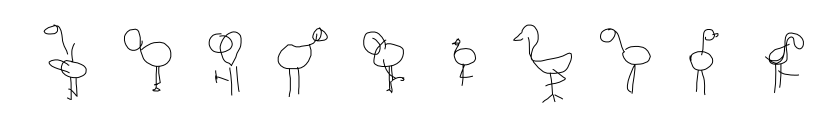

In [37]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [38]:
model_dir = '/tmp/sketch_rnn/models/owl/lstm'

In [39]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/owl/lstm/vector


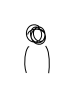

In [40]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

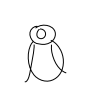

In [41]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [42]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

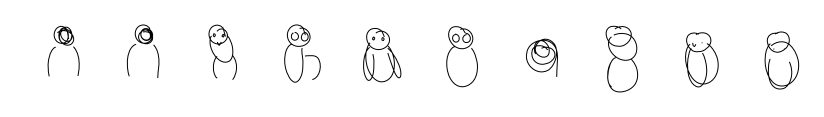

In [43]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [44]:
model_dir = '/tmp/sketch_rnn/models/catbus/lstm'

In [45]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/catbus/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/catbus/lstm/vector


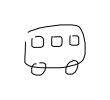

In [46]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

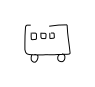

In [47]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [48]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

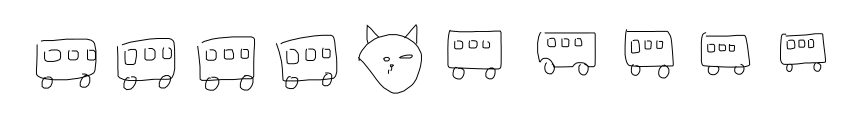

In [49]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [50]:
model_dir = '/tmp/sketch_rnn/models/elephantpig/lstm'

In [51]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model /tmp/sketch_rnn/models/elephantpig/lstm/vector.
INFO:tensorflow:Restoring parameters from /tmp/sketch_rnn/models/elephantpig/lstm/vector


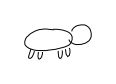

In [52]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

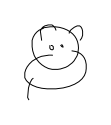

In [53]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [54]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.15), [0, i]])

In [55]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

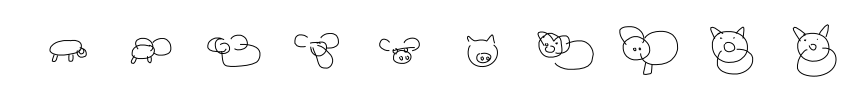

In [56]:
draw_strokes(stroke_grid, factor=0.3)